In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set()
%matplotlib inline

In [101]:
import unidecode

def normalizeSentence(sentence):
    
    temp = sentence.split(' ')
    new_sentence = []
    for word in temp:
        new_sentence.append(normalizeWord(word))
    new_sentence = ' '.join(new_sentence)
    
    return new_sentence

def normalizeWord(word):
    
    # lower case word
    word = word.lower()
    
    # remove accents
    word = unidecode.unidecode(word)
    
    return word

def joinSeparetedWord(word):
    
    # removing aspas
    word = word.split('\'')
    word = ''.join(word)
    
    # separete words from word
    word = word.split()
    
    # join separeted words by '-'
    word = '-'.join(word)
    
    return word

In [102]:
def selectByWord(word, sentences):
    # select subset of sentences that contains word
    # return indexs of sentences
    
    # normalize word
    normalized_word = normalizeWord(word)
    
    indexs = []
    
    for i, sentence in enumerate(sentences):
        # normalize sentence
        normalized_sentence = normalizeSentence(sentence)
        
        if normalized_word in normalized_sentence:
            #print(i, normalized_sentence)
            indexs.append(i)
    return indexs

In [103]:
def selectDfRowsByWord(data, word, column):
    '''
    Select specific rows that contains especific word in the column
    '''
    
    sentences = np.array(data[column].unique())

    # find sentences
    idxs = selectByWord(word, sentences)
    obj_sentences = sentences[idxs]

    servicos = pd.DataFrame()
    for sentence in obj_sentences:

        # select rows of exemplo
        temp = data[data[column] == sentence]

        # concatenate
        servicos = pd.concat([servicos, temp])
    try:
        temp = len(servicos[column].unique())
    except:
        print(word + ': Not found')
    
    return servicos.copy()

In [104]:
def calcDespesa(date, base, programa = None):
    '''
    Cálculo da despesa: empenhado - anulacao + reforco
    date: [{year}, {month}]
    base: pd.DataFrame
    programa: {str}
    '''
    year = date[0]
    month = date[1]
    
    temp = base.copy()
    if programa is not None:
        temp = base[base['ds_programa'] == programa].copy()
    temp = temp[(temp['ano_exercicio'] == year) & (temp['mes_referencia'] == month)]
    empenhado = temp[temp['tp_despesa'] == 'empenhado']['vl_despesa_per_capita'].sum()
    anulacao = temp[temp['tp_despesa'] == 'anulacao']['vl_despesa_per_capita'].sum()
    reforco = temp[temp['tp_despesa'] == 'reforco']['vl_despesa_per_capita'].sum()
    
    despesa = empenhado - anulacao + reforco
    
    del temp
    return despesa

In [116]:
class Municipio:
    '''
    
    Município
    
    '''
    
    def __init__(self, name, years = (2018, 2018), onlyAmbiental = False):
        
        self.keep_columns_ = ['ano_exercicio', 'mes_ref_extenso', 'mes_referencia', 'tp_despesa', 'vl_despesa',
                              'ds_funcao_governo', 'ds_subfuncao_governo', 'ds_programa', 'ds_acao']
        self.numeric_columns_ = ['ano_exercicio', 'vl_despesa', 'mes_referencia']
        
        self.years_ = np.arange(years[0], years[1]+1)
        self.name_ = normalizeWord(name)
        self.df_ = pd.DataFrame()
        self.population_ = None
        self.iamb_ = None
        self.regiao_ = None
        self.lat_ = None
        self.long_ = None
        self.onlyAmbiental_ = onlyAmbiental
        self.serie_ = pd.DataFrame()
        
        print('Reading data...')
        self.readData()
        print('Preparing data...')
        self.prepareData()
        print('Preparing serie...')
        self.prepareSerie()
        print('\nBase for {} is ready!!'.format(self.name_))
        
    def readData(self):
        
        print('> reading population, i-Amb, lat, long...')
        # reading population, i-amb...
        
        municipios_base = pd.read_csv('datasets/municipios.csv')
        municipios = municipios_base['Município'].values
        for i, municipio in enumerate(municipios):
            if normalizeWord(self.name_) == normalizeWord(municipio):
                self.population_ = municipios_base['Estimativa 2019'].values[i]
                self.lat_ = municipios_base['Latitude'].values[i]
                self.long_ = municipios_base['Longitude'].values[i]
                self.iamb_ = municipios_base['i-Amb'].values[i]
                self.regiao_ = municipios_base['Região Administrativa'].values[i]
        if self.population_ is None:
            print('Erro: population not found')
            return
        
        print('> reading despesas...')
        # reading despesas
        
        for year in self.years_:
            print('>> year: '+str(year))
            try:
                aux = open('datasets/despesas/'+ str(year) +'/despesas-' + self.name_ + '-'+str(year)+'.csv', 'r')
                aux.close()
                del aux
            except:
                downloadDespesas([self.name_], year, unzip=True)
            temp = pd.read_csv('datasets/despesas/'+ str(year) +'/despesas-' + self.name_ + '-'+str(year)+'.csv', sep = ';',  encoding = "ISO-8859-1")
            temp = temp[self.keep_columns_]
            self.df_ = pd.concat([self.df_, temp]).reset_index(drop = True)
        del temp
        
    def prepareData(self):
        
        print('> removing NaN...')
        # remove nan values
        self.df_ = self.df_.dropna()
        
        # string para float
        self.df_['vl_despesa'] = self.df_.vl_despesa.apply(lambda x : float('.'.join(x.split(','))))
        
        print('> normalizing words...')
        # normalizando nome dos meses
        for column in self.df_.columns:
            if column in self.numeric_columns_:
                 continue
            self.df_[column] = self.df_[column].apply(lambda x : normalizeWord(x))
        
        self.df_['vl_despesa_per_capita'] = self.df_['vl_despesa'].apply(lambda x : x/self.population_)
        
        # ajsutando nomes com . no meio
        for column in ['ds_programa', 'ds_acao']:
            self.df_[column] = self.df_[column].apply(lambda x : ''.join(x.split('.')))
            
        # only gestao ambiental
        if self.onlyAmbiental_:
            self.df_ = self.df_[self.df_['ds_funcao_governo'] == 'gestao ambiental']
        
        
    def prepareSerie(self):
        
        dates = []
        for year in self.years_:
            for month in range(1, 13):
                if month < 10:
                    str_month = '0'+str(month)
                else:
                    str_month = str(month)
                dates.append(str(year)+'-'+str_month)
        self.serie_['date'] = dates
        for programa in self.df_['ds_programa'].unique():
            valor_programa = []
            for year in self.years_:
                for month in range(1, 13):
                    valor = calcDespesa([year, month], self.df_, programa)
                    valor_programa.append(valor)
            self.serie_[programa] = valor_programa
        
        self.serie_ = self.serie_.set_index('date')
        
        total = []
        for date in self.serie_.index:
            total.append(self.serie_.loc[date].values.sum())
        self.serie_['total'] = total
        
    def plotSerie(self, programas = None):
        
        if programas is None:
            programas = ['total']
            
        plt.figure(figsize=(14,8))
        for programa in programas:
            plt.plot(self.serie_[programa], lw = 3, label = programa)
            
            aux = self.serie_[programa].values.reshape(-1)
            x = np.arange(len(aux))
            plt.fill_between(x, y1 = np.zeros(len(aux)), y2 = aux, lw = 3, alpha = 0.3)
        plt.xticks(rotation=80)
        plt.title(self.name_ + ' - gestão ambiental')
        plt.ylabel('vl_despesa_per_capita (R$)')
        plt.xlabel('data')
        plt.legend()
        
        

In [117]:
from zipfile import ZipFile
import urllib.request
import progressbar
import os

def downloadDespesas(names, year, unzip = False):
        
    n = len(names)
    erros = []

    for i in range(n):
        name = names[i]

        # uniformalizing word for match
        name = normalizeWord(name)

        # replacing ' ' to '-'
        name = joinSeparetedWord(name)

        # request download
        url = 'https://transparencia.tce.sp.gov.br/sites/default/files/csv/despesas-' + name + '-' + str(year) + '.zip'
        try:
            zipName = 'downloads/' + name + '-' + str(year) + '.zip'
            urllib.request.urlretrieve(url, zipName)
            if unzip:
                with ZipFile(zipName, 'r') as zipObj:
                    zipObj.extractall('datasets/despesas/' + str(year))
                try:
                    os.rename('datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '.zip.csv', 'datasets/despesas/' + str(year) + '/despesas-' + name + '-' + str(year) + '.csv')
                except:
                    continue
        except:
            erros.append(name)
        
    if len(erros) == 0:
        print('All files have been downloaded!')
    else:
        print('Files not found:')
        print(erros)
    

In [118]:
municipios = pd.read_csv('datasets/municipios.csv').set_index('Município')

In [119]:
municipios_nomes = ['Caraguatatuba']

In [120]:
sample = municipios.loc[municipios_nomes]

In [121]:
sample

,Posição,Estimativa 2019,Latitude,Longitude,Região Administrativa,Porte,i-Amb
Município,,,,,,,
Caraguatatuba,71,121532,-23.6125,-45.4125,Região Administrativa de São José dos Campos,Médio,B+


In [122]:
downloadDespesas(sample.index, unzip = True, year = 2016)

All files have been downloaded!


In [123]:
exemplo = Municipio('ilhabela', years = (2014, 2018), onlyAmbiental=True)

Reading data...
> reading population, i-Amb, lat, long...
> reading despesas...
>> year: 2014
>> year: 2015
>> year: 2016
>> year: 2017
>> year: 2018
Preparing data...
> removing NaN...
> normalizing words...
Preparing serie...

Base for ilhabela is ready!!


In [124]:
exemplo.serie_.columns
programas = ['+eficiencia +efetividade com equidade', 'parceria inteligente',
       'gestao de residuos', 'gestao institucional',
       'ecologia e sustentabilidade', 'fundo municipal de meio ambiente',
       'saneamento - residuos solidos', 'reflorestamento e paisagismo']

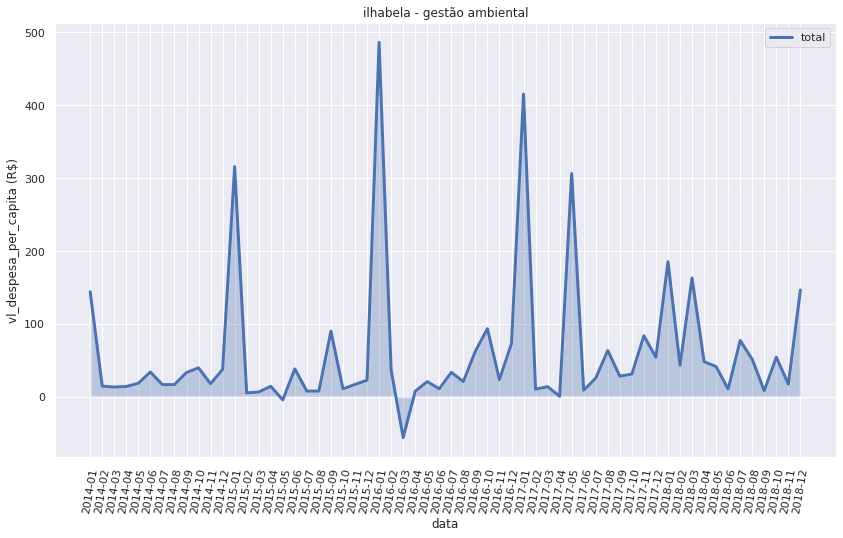

In [125]:
exemplo.plotSerie()

In [126]:
exemplo.serie_

,+eficiencia +efetividade com equidade,parceria inteligente,gestao de residuos,gestao institucional,ecologia e sustentabilidade,fundo municipal de meio ambiente,saneamento - residuos solidos,reflorestamento e paisagismo,total
date,,,,,,,,,
2014-01,4.668308,67.154464,72.035115,0.000000,0.000000,0.000000,0.000000,0.000000,143.857887
2014-02,4.120975,9.765585,0.438862,0.000000,0.000000,0.000000,0.000000,0.000000,14.325423
2014-03,3.498013,9.082272,0.401058,0.000000,0.000000,0.000000,0.000000,0.000000,12.981343
2014-04,3.659408,9.746422,0.382205,0.000000,0.000000,0.000000,0.000000,0.000000,13.788035
2014-05,3.723268,14.372311,0.126617,0.000000,0.000000,0.000000,0.000000,0.000000,18.222196
2014-06,5.476260,27.406557,0.786102,0.000000,0.000000,0.000000,0.000000,0.000000,33.668919
2014-07,4.232862,11.932174,0.193297,0.000000,0.000000,0.000000,0.000000,0.000000,16.358333
2014-08,5.174409,10.361939,0.901859,0.000000,0.000000,0.000000,0.000000,0.000000,16.438206
2014-09,3.722476,29.263905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.986381
